# Project Cornelia data analysis

> This notebook was created as part of the examination requirements of "Introduction to Digital Humanities" class offered by the Master of Digital Humanities programme in KU Leuven. A replicable version of all the code (environment setup, data cleaning and processing, analysis pipeline orchestration) responsible for producing the data required for this analysis can be found in the [assignment's GitHub repository.](https://github.com/ejgenc/data-analysis_cornelia) It is recommended to use the code and the guidelines there to re-create a Conda environment that this notebook can run in.

## What's this notebook about?

[***Project Cornelia***](https://projectcornelia.be/) is a Digital Humanities research project that lies in the intersection of art history and computer science. It is a project in which computational methods are used to aggregate, study, analyze and visualize data about 17th century Flemish art, with a focus on painting and tapestry.

This notebook offers a brief exploratory data analysis of a small subset of the data offered by Project Cornelia. The data subset that serves as the basis of the exploratory data analysis is the digitized records of a artist's guildbook found in Brussels. It contains chronologically organized and annotated entries about Flemish artists, their roles and their ranks.

## Setup

### Import the required Python packages

In [346]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

### Import the data

In [347]:
input_fp = Path("../data/cleaned/cornelia-cleaned.csv")
dataset = pd.read_csv(input_fp, encoding="utf-8",
                      sep=";")

### Define visualization presets and helper functions

In [348]:
# Figure
mpl.rcParams["figure.facecolor"] = "F7F2E8"
mpl.rcParams["figure.edgecolor"] = "F7F2E8"

# Axes
mpl.rcParams["axes.facecolor"] = "F7F2E8"
mpl.rcParams["axes.edgecolor"] = "312C25"
mpl.rcParams["axes.labelcolor"] = "312C25"

# Ticks
mpl.rcParams["xtick.color"] = "312C25"
mpl.rcParams["ytick.color"] = "312C25"

# Typography
mpl.rcParams["font.family"] = "Constantia"
mpl.rcParams["font.size"] = 12
mpl.rcParams["text.color"] = "312C25"

# custom colormap
colors = ["#f7f2e8", "#efebe2", "#e7e4dd", "#dfddd7", "#d8d6d1", "#d0d0cc",
          "#c8c9c6", "#c0c2c0", "#b9bbbb", "#b1b5b5", "#aaaeb0", "#a2a8aa",
          "#9ba1a5", "#939ba0", "#8c949a", "#858e95", "#7e8790", "#76818a",
          "#6f7b85", "#687580", "#616f7b", "#5a6976", "#536371", "#4c5d6c",
          "#455766", "#3e5162", "#374c5d", "#304658", "#294053", "#223b4e"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

## Exploratory data analysis

### The number of actors in the dataset

The main entities of interest in this dataset are the **actors.** The actors are 17th century Flemish artists who take up professions such as painter, glass-maker, goldsmith and tapestry maker. It is a good idea to draw attention to them first, and the first thing that we can look at is **how many actors there are in the dataset.**

The actors in the dataset can be identified in two different ways:
- Through a name + surname combination
- Through the ID's that have been assigned to them by the researchers

Choosing the ID's as an identifier is the most reliable way of counting actors. As the dataset comes from a register that was kept over time, the same names may appear more than once. Furthermore, names, surnames and their combinations can be shared by multiple people. Still, we can take a peek at the names in the dataset to familiarize ourselves more with the actors.

In [349]:
# --- data prep ---
top_names = (dataset.loc[:, ["actor_id", "actor_first_name"]]
             .groupby("actor_id")
             .first()
             .reset_index()
             ["actor_first_name"]
             .value_counts()
             .reset_index()
             .rename({"index": "value", "actor_first_name": "count"}, axis=1)
             [:5])

top_snames = (dataset.loc[:, ["actor_id", "actor_surname"]]
              .groupby("actor_id")
              .first()
              .reset_index()
              ["actor_surname"]
              .value_counts()
              .reset_index()
              .rename({"index": "value", "actor_surname": "count"}, axis=1)
              [:5])

top_fullnames = pd.DataFrame(dataset["actor_id"])
top_fullnames["fullname"] = (dataset["actor_first_name"]
                             + " " 
                             + dataset["actor_surname"])
top_fullnames = (top_fullnames
                 .groupby("actor_id")
                 .first()
                 .reset_index()
                 ["fullname"]
                 .value_counts()
                 .reset_index()
                 .rename({"index": "value", "name": "count"}, axis=1)
                 [:5])

# Formatted print
for title, data in zip(["first names", "surnames", "fullnames"],
                       [top_names, top_snames, top_fullnames]):
    print("Showing top five {}".format(title))
    print(data)
    print("\n")

Showing top five first names
         value  count
0          Jan    102
1        Peter     56
2     Francois     54
3  Jan Baptist     28
4        Jacob     25


Showing top five surnames
       value  count
0  Ringheler      9
1  De Backer      9
2     Jacobs      8
3    Coppens      6
4  Geeraerts      6


Showing top five fullnames
                    value  fullname
0        Francois Coppens         2
1              Jan Symons         2
2         Peter De Backer         2
3        Francois Mossens         2
4  Hendrick Van den Steen         2




The three small tables above confirm our belief that not even name + surname combinations are good unique identifiers. There are at least five full names that are shared by more than one person. The tables also reveal the most popular names and surnames. For example, "Jan" and "Peter" are the two most popular names whereas "Ringheler" and "De Backer" are the two most popular surnames.

Now that we know the most popular five names, surnames and full names, we can count the number of unique actors in the dataset. A simple sum reveals to us that there are **735** unique actors in the dataset.

In [350]:
# Counting the number of unique actors in the dataset through counting the number of unique id's.
print(dataset.loc[:, "actor_id"].nunique())

735


### Actor roles and actor status

There are two features in the dataset that allow us to get a more fine-grained classification of the actors. Those two features are **actor roles** and **actor status.** 

#### Actor roles

All of the actors in our dataset are artists. The actor role feature gives information about exactly what type of artist any given actor is. There are seven distinct actor roles in the dataset: painter, glazier, goldsmith, gilder, glass painter, plate craftsman and pharmacist. Some of the roles such as "painter" and "goldsmith" are straightforward whereas some roles as "plate craftsman" and "pharmacist" are more obscure. It is not possible to discover why there is a pharmacist in the dataset from the data that is provided for this assignment.

Below is a bar chart that shows the distribution of the roles in the dataset.

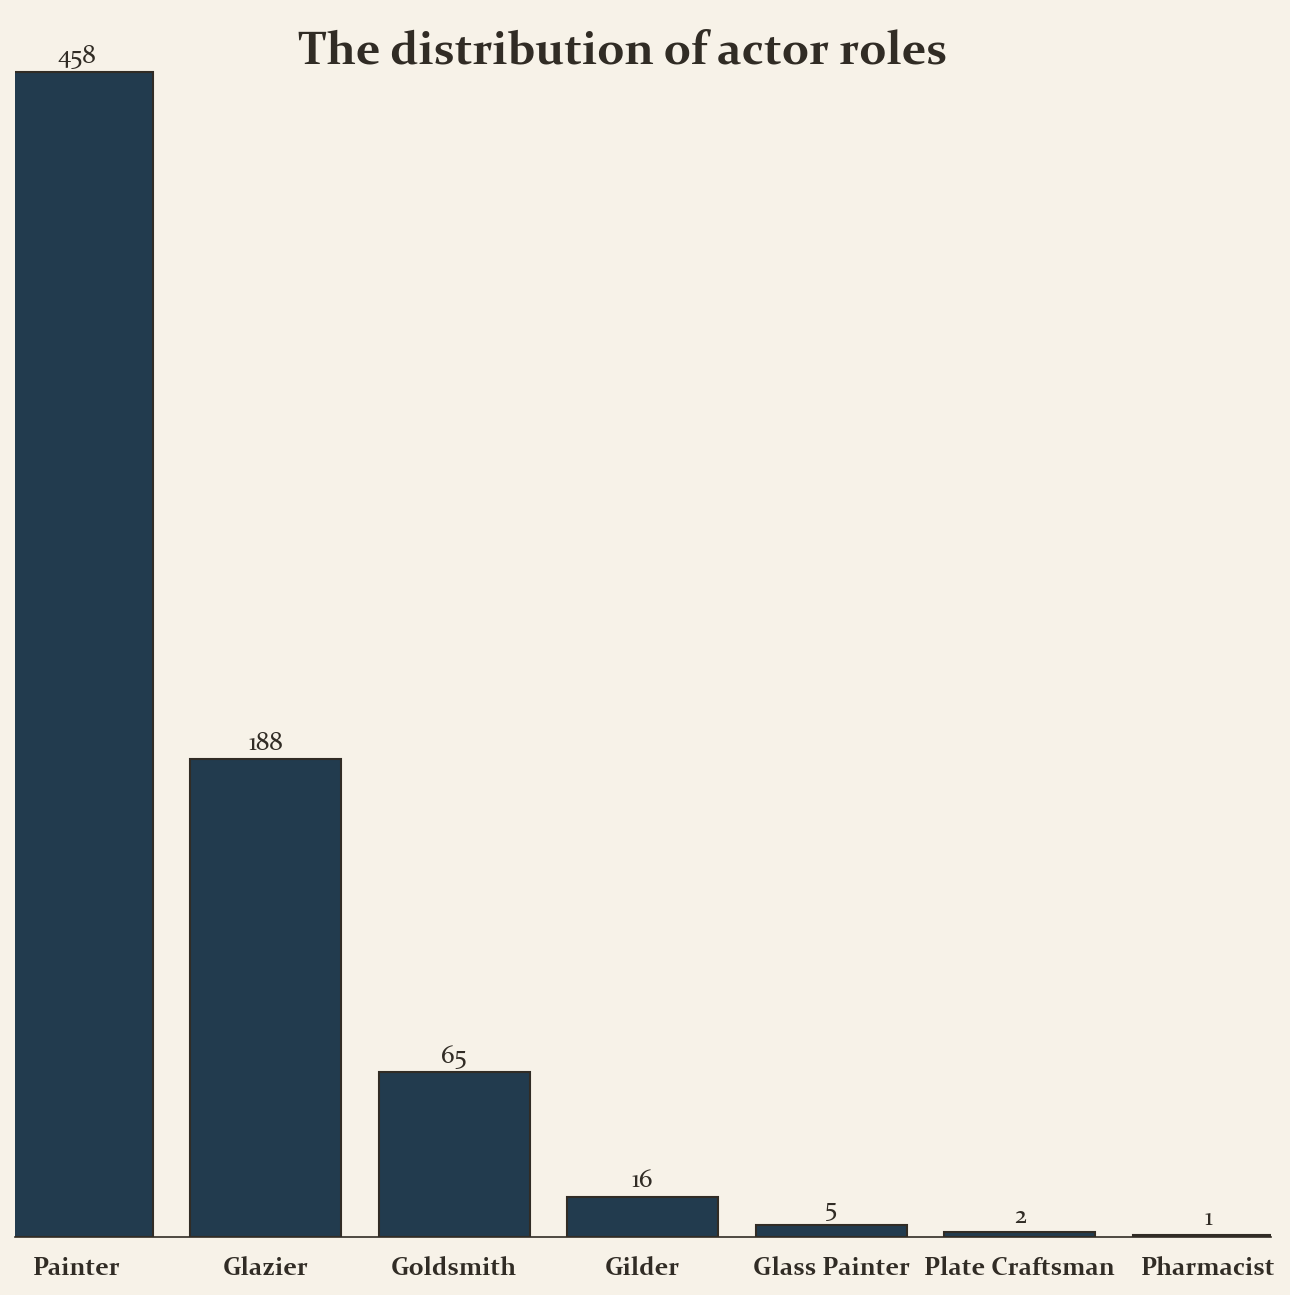

In [351]:
# --- data prep ---
subset = (dataset.loc[:, ["actor_id", "role"]]
               .groupby("actor_id")
               .first()
               .reset_index()
               .drop(["actor_id"], axis=1)
               .value_counts()
               .reset_index()
               .rename({0: "count"}, axis=1))

# --- fig setup ---
fig = plt.figure(figsize=(10.80, 10.80),
                 dpi=150)

ax = fig.add_subplot(1, 1, 1)

# --- plot ---
bar = ax.bar(x=[0, 1, 2, 3, 4, 5, 6],
             height=subset["count"],
             tick_label=subset["role"].str.title(),
             color="#223B4E",
             linewidth=1,
             edgecolor="#312C25",
             align="center")

# --- configure params --- 
# spines and axes
for spine in ["left", "right", "top"]:
    ax.spines[spine].set_visible(False)
ax.axes.set_xlim(-0.33, 6.33)

# axis ticks
ax.set_yticks([])

ax.tick_params(axis = "both",
    which = "both",
    bottom = False,
    top = False,
    left = False,
    right = False,
    pad = 5)

# titles and annotation
# fig title
plt.figtext(s="The distribution of actor roles",
          x=0.50,
          y=0.85,
          va="baseline",
          ha="center",
          fontsize=22,
          fontweight="bold")
          
# axis labels
ax.set_xticklabels(subset["role"].str.title(),
                   fontsize=12,
                   fontweight = "bold")

# tick labels
ax.set_yticklabels([])

# bar annotation
labels = ax.bar_label(bar, padding=2)


As it can be seen from the bar chart above, the role of "painter" dominates over all other roles by a wide margin. There are 458 painters recorded in the dataset, following by 188 glaziers and 65 goldsmiths. The other four roles make up an insignificant percentage when compared to the top three roles.

Now that we know what roles there are in the dataset and their prevalence levels, we can look at the actor status feature.

#### Actor status

All of the artists in the dataset have a status attached to them as well as a role. The status of an actor signifies his/her experience level, often tied with the time spent with the guild. There are six distinct status recorded in the guild books: apprentice, master, non-sworn in master, master's son, tutor and dean. These roles present to us some kind of a partial hiearchy: The status of "apprentice" (the most populous status group) is lower in rank than the status of master, the status of master is lower in rank than the status of tutor, and the status of master is lower in rank than the status of dean. The two remaining roles cannot exactly be placed within this hierarchy. The dataset does not provide any information about whether non-sworn in master's are held in the same regard as in sworn-in masters, and the artistic merit of a master's son is questionable.

Below is another bar chart that shows the distribution of the feature "actor status".

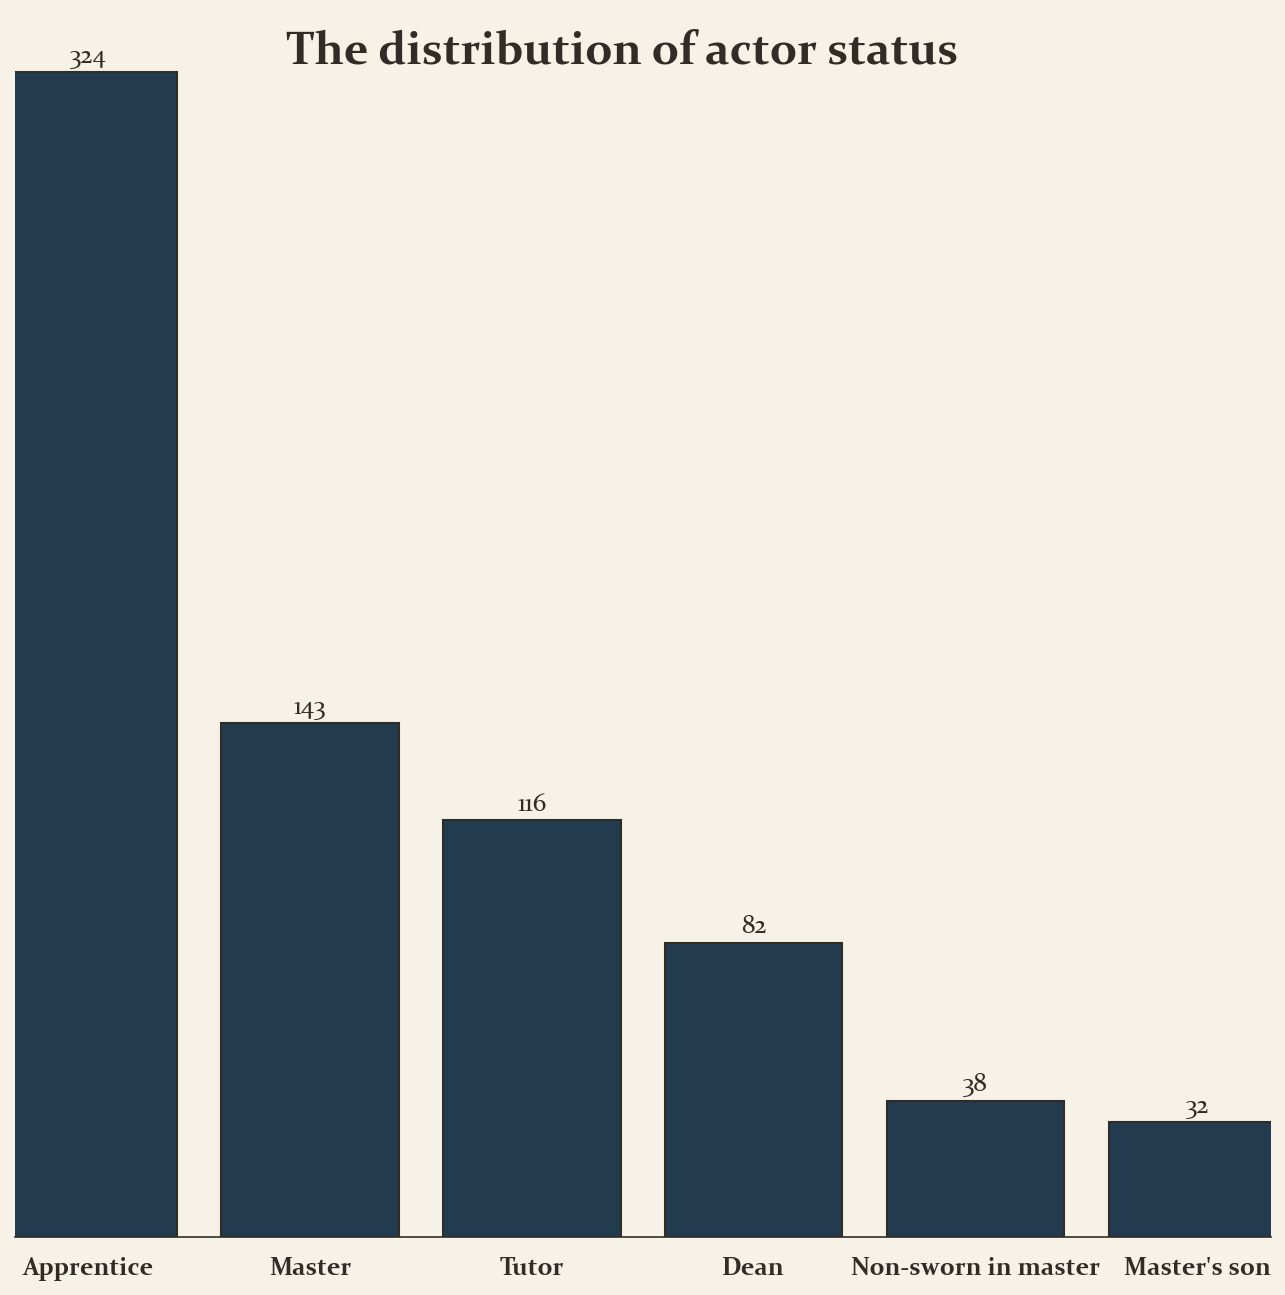

In [352]:
# --- data prep ---
subset = (dataset.loc[:, ["actor_id", "status"]]
               .groupby("actor_id")
               .first()
               .reset_index()
               .drop(["actor_id"], axis=1)
               .value_counts()
               .reset_index()
               .rename({0: "count"}, axis=1))

# --- fig setup ---
fig = plt.figure(figsize=(10.80, 10.80),
                 dpi=150)

ax = fig.add_subplot(1, 1, 1)

# --- plot ---
bar = ax.bar(x=[0, 1, 2, 3, 4, 5],
             height=subset["count"],
             tick_label=subset["status"].str.title(),
             color="#223B4E",
             linewidth=1,
             edgecolor="#312C25",
             align="center")

# --- configure params --- 
# spines and axes
for spine in ["left", "right", "top"]:
    ax.spines[spine].set_visible(False)
ax.axes.set_xlim(-0.33, 5.33)

# axis ticks
ax.set_yticks([])

ax.tick_params(axis = "both",
    which = "both",
    bottom = False,
    top = False,
    left = False,
    right = False,
    pad = 5)

# titles and annotation
# fig title
plt.figtext(s="The distribution of actor status",
          x=0.50,
          y=0.85,
          va="baseline",
          ha="center",
          fontsize=22,
          fontweight="bold")
          
# axis labels
ax.set_xticklabels(subset["status"].str.capitalize(),
                   fontsize=12,
                   fontweight = "bold")

# tick labels
ax.set_yticklabels([])

# bar annotation
labels = ax.bar_label(bar, padding=2)

The distribution of actor status over the dataset mirrors the hierarchical structure of the status: there are more apprentices than there are masters, there are more masters than there are tutors, and there are more tutors than there are deans. What's surprising is the fact that the status of "non-sworn in master" and "master's son" are prevalent in significant levels.

#### Interaction of actor role and actor status

These two crucial categorical features can also be investigated in unison. It might be interesting to know statistics like:
- The percentage of apprentices that were painters versus the percentage of apprentices that were goldsmiths
- The percentage of masters that were pharmacist versus the percentage of masters that were glaziers.


A data visualization can inform us about such statistics.

Text(0.155, 0.99, 'Pie sizes differ in relation to the number of actors with the specified status')

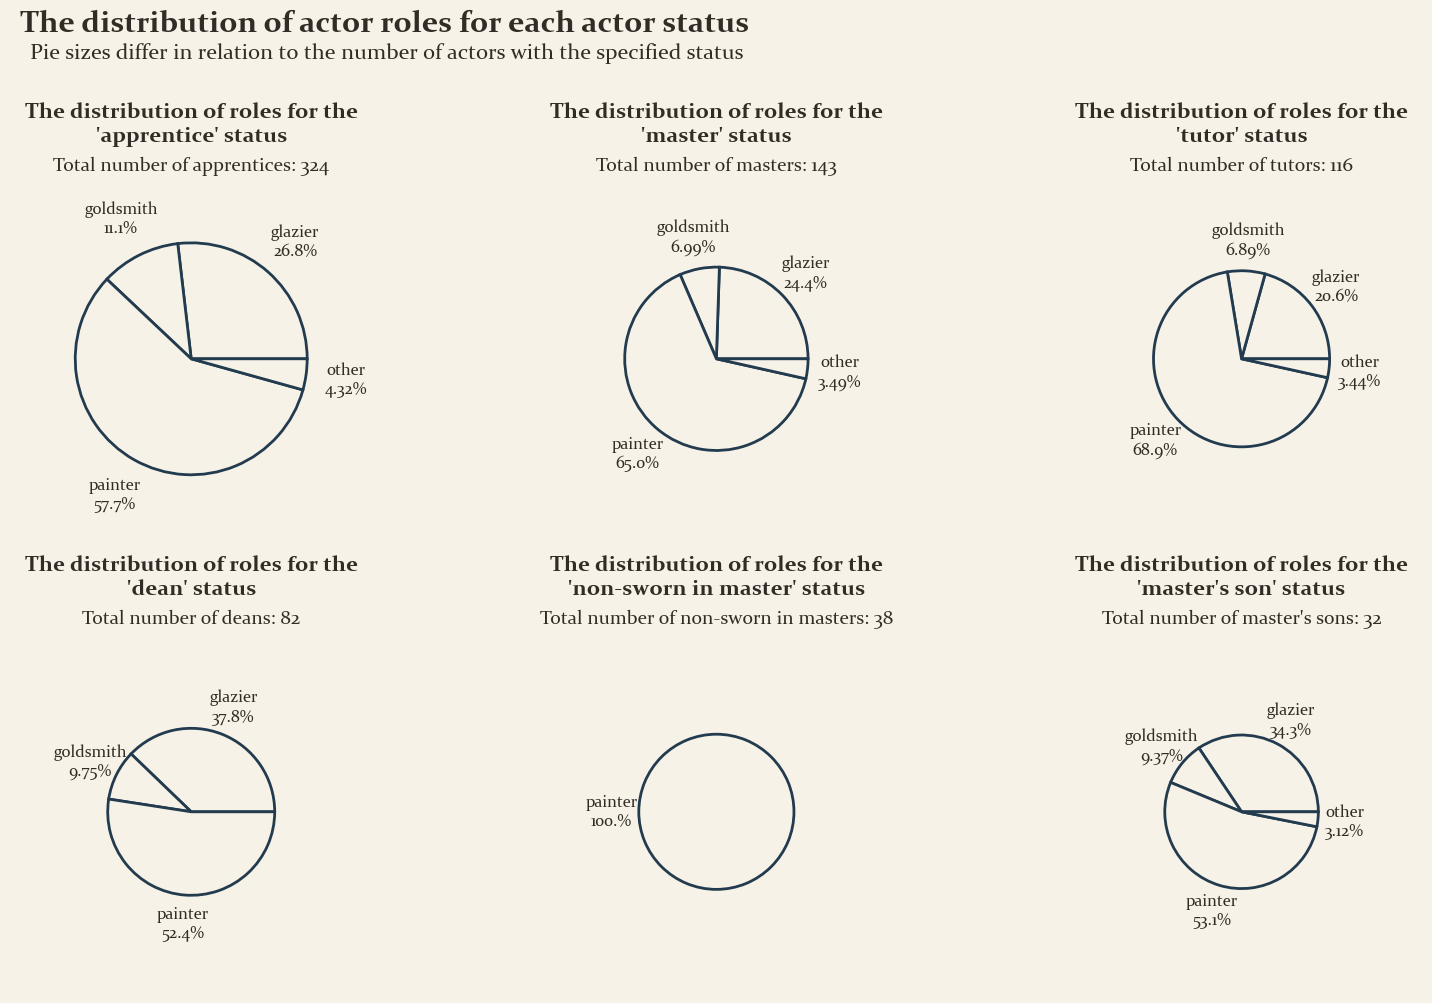

In [353]:
# --- data prep ---
subset_groups = (dataset.loc[:, ["actor_id", "role", "status"]]
               .groupby("actor_id")
               .first()
               .reset_index()
               .drop(["actor_id"], axis=1)
               .groupby("status"))

group_titles = ["apprentice", "master", "tutor",
                "dean", "non-sworn in master", "master's son"]
subsets = {}
for group_title in group_titles:
    group = subset_groups.get_group(group_title)
    group = (group
             .groupby("role")
             .agg({"status": "count"})
             .reset_index()
             .rename({"status": "count"}, axis=1))
    group["perc"] = ((group["count"] / group["count"].sum()) * 100)

    other_mask = group["perc"] < 5
    if sum(other_mask > 0):
        other_subset = group.loc[other_mask, ["count", "perc"]].sum()
        other_row = pd.Series(["other", other_subset["count"], other_subset["perc"]], group.columns)

        group = (group
                 .loc[~other_mask, :]
                 .append(other_row, ignore_index=True))

    subsets[group_title] = group

# --- fig setup ---
fig = plt.figure(figsize=(19.20, 10.80),
                 dpi=100)
spec = fig.add_gridspec(ncols=3, nrows=2, hspace=0.25)

locs = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
for loc in locs:
    fig.add_subplot(spec[loc[0], loc[1]])

for title, data, ax in zip(subsets.keys(), subsets.values(), fig.axes):

# --- more data prep --- 
    labels = (data["role"]
              + "\n"
              + data["perc"].astype(str).str[:4]
              + "%")
    r = np.interp(data["count"].sum(), [0, 324], [0.5, 0.8])
# --- plot ---
    ax.pie(x=data["perc"],
            labels=labels,
            labeldistance=1.35,
            radius=r,
            startangle=0,
            wedgeprops={
                "linewidth": 2,
                "ec": "#223B4E",
                "fc": "#F7F2E8"
            },
            textprops={
                "ha": "center",
                "fontweight": "normal",
                "fontsize": 12
            })

#configure params
# --- configure params --- 

# spines, axes and axis ticks
    for spine in ["left", "right", "top", "bottom"]:
        ax.spines[spine].set_visible(False)

    # axis ticks
    ax.set_yticks([])
    ax.set_xticks([])

    ax.tick_params(axis = "both",
        which = "both",
        bottom = False,
        top = False,
        left = False,
        right = False,
        pad = 5)

    # axis tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # ax title
    ax.text(s="The distribution of roles for the\n'{}' status".format(title),
          x=0,
          y=1.5,
          va="baseline",
          ha="center",
          fontsize=16,
          fontweight="bold")

    # ax subtitle
    ax.text(s="Total number of {}s: {}".format(title, str(sum(data["count"].astype(int)))),
        x=0,
        y=1.3,
        va="baseline",
        ha="center",
        fontsize=14,
        fontweight="normal")

# fig title
plt.figtext(s="The distribution of actor roles for each actor status",
          x=0.15,
          y=1.015,
          va="baseline",
          ha="left",
          fontsize=22,
          fontweight="bold")

plt.figtext(s="Pie sizes differ in relation to the number of actors with the specified status",
          x=0.155,
          y=0.990,
          va="baseline",
          ha="left",
          fontsize=16,
          fontweight="normal")


As it can be seen from the small multiples pie chart above, painters make up more than half percent of any actor status no matter what the status is. This is in line with the fact that the most common actor role in the dataset is painter. In fact, the distribution of roles for all actor status closely follows the general prevalence order of roles: painters come first, followed by glaziers and then by goldsmiths. 

The data visualization also reveals some other important details such as:

- There are practically no gilders, glass painters, plate crafters or pharmacists that served as deans.
- All of the non-sworn in masters in the dataset are painters.
- 
### Temporality

All of the entries in the dataset have dates attached to them. These dates give information about exactly when an entry was recorded in the guild book of Brussels. The recorded dates found in the dataset can be granular as some entries are exact to the level of month, and some are to the level of day and month. However, there is a significant amount of entries that have either their recording day or recording month information missing. Because of this, it might be a better idea to base our analysis about the temporal dimension of the dataset on years only.

Below is a data visualization that shows the distribution of entry years.

Text(0.33, 0.915, 'Earliest year: 1599     Latest year: 1706     Median year: 1644')

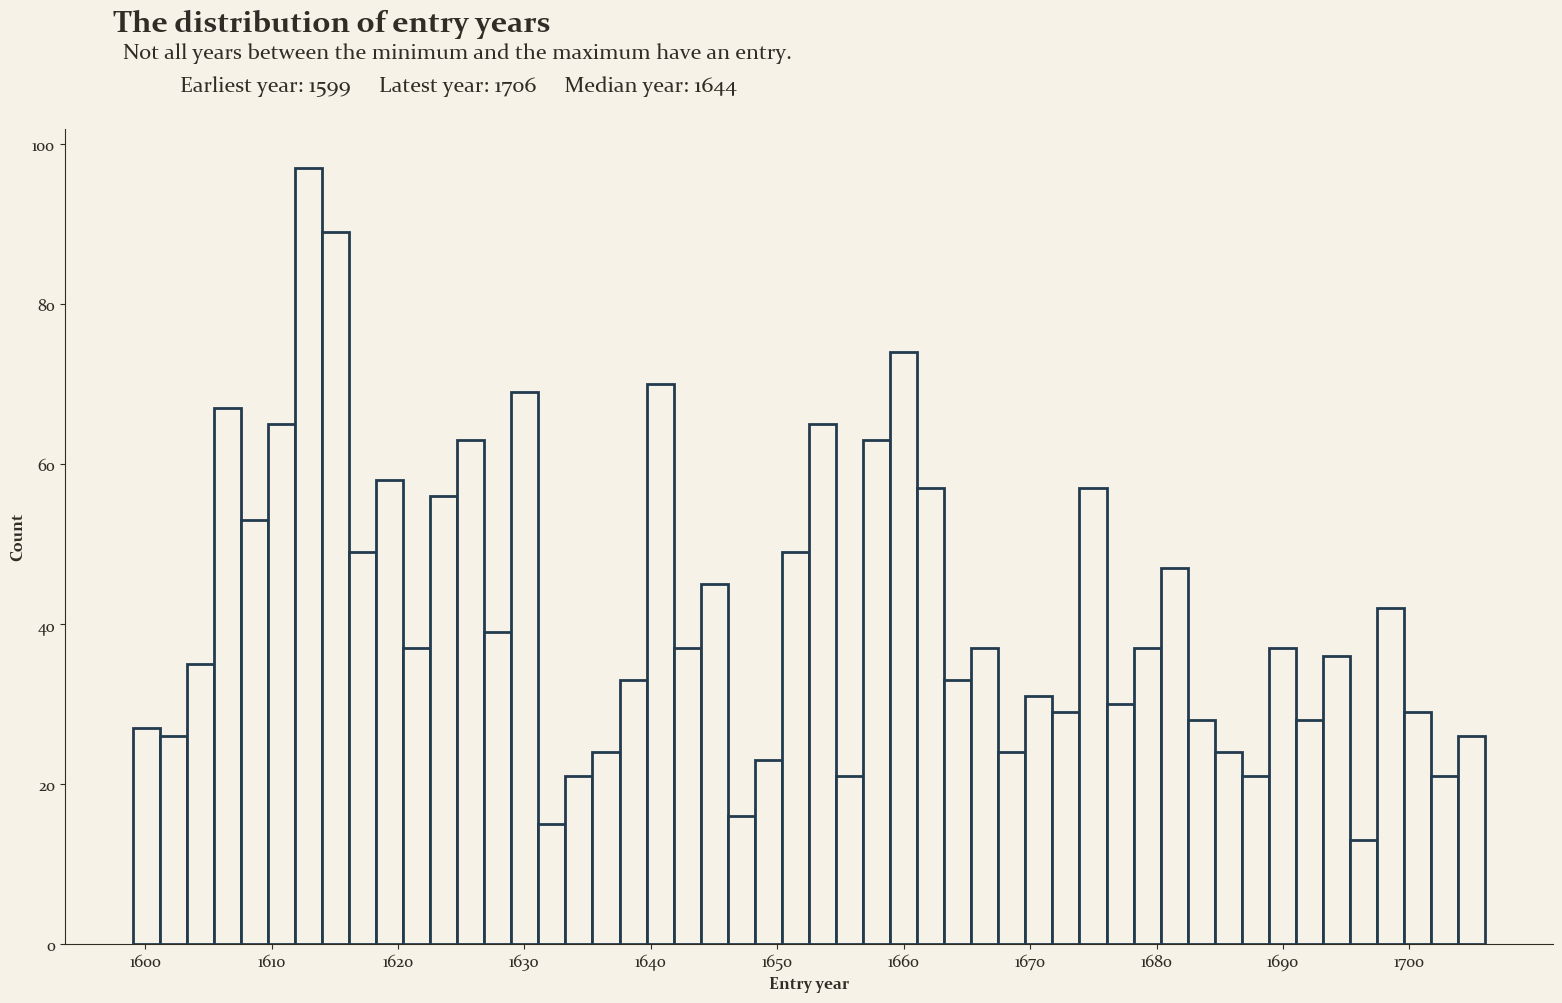

In [354]:
# --- data prep ---
subset = (dataset.loc[:, ["date_year"]])

# --- fig setup ---
fig = plt.figure(figsize = (19.20, 10.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1)

# --- plot ---
hist = ax.hist(x=subset,
               bins=50,
               histtype="bar",
               color="#F7F2E8",
               edgecolor="#223B4E",
               lw=2)

# spines, axes and axis ticks
for spine in ["right", "top"]:
    ax.spines[spine].set_visible(False)

# axis ticks
ax.set_xticks([i for i in range(1600, 1701, 10)])

# title, subtitles, axis labels and annotations
# fig title
plt.figtext(s="The distribution of entry years",
          x=0.15,
          y=0.97,
          va="baseline",
          ha="left",
          fontsize=22,
          fontweight="bold")

# fig subtitle
plt.figtext(s="Not all years between the minimum and the maximum have an entry.",
          x=0.155,
          y=0.945,
          va="baseline",
          ha="left",
          fontsize=16,
          fontweight="normal")

# axis annotation
ax.set_ylabel("Count",
              fontsize=12,
              fontweight="bold")

ax.set_xlabel("Entry year",
              fontsize=12,
              fontweight="bold")

# annotation
plt.figtext(s=("Earliest year: {}     Latest year: {}     Median year: {}")
                .format(subset.min()[0], subset.max()[0], int(subset.median()[0])),
          x=0.33,
          y=0.915,
          va="baseline",
          ha="center",
          fontsize=16,
          fontweight="normal")


As it can be seen above, the entries in the guild book span more than a hundred years. The record keeping activity seems to have waxed and waned over the years, as around three distinct "activity peaks" can be spotted within the histogram.

Knowing when an entry was recorded into the guild register does not give us much information about the entities of interest in our analysis, which are the artists. However, our dataset has two curious features closely tied to temporality that can lead us to gain detailed insights about them:

- Some people appear in the guild register more than once in different years.
- In some of those appearances, artists have a different actor status than their last appearance.

**These two features mean that we can track an individual artist's journey through the guild. We can track how long s/he appears in the guild registers, and we can track the artist's "career progression" by looking at the interaction of time and actor status.**

#### An artist's journey

The data visualization below plots each artist's journey in an abstract way. The lines represent individual artists and line lengths represent for how long an artist appears in the guild registry. Line starts and ends are placed on the actual years as they appear on the X-axis. Lines are placed on the Y-axis by journey start dates: the closer the first entry mentioning an artist is to 1599, the lower the line appears on the Y-axis. Non-sworn in master's and master's son are excluded from the analysis.


In [375]:
# --- data prep ---
status_rank_dict = {"apprentice": 1,
                    "master": 2,
                    "tutor": 3,
                    "dean": 4}
journeys = []

valid_status_mask = ~(dataset["status"].str.contains("non-sworn in master|master's son"))
subset = (dataset
          .loc[valid_status_mask,
               ["actor_first_name", "actor_surname", "actor_id", "role", "status", "date_year"]])

subset_grouped = subset.groupby("actor_id")
for id in subset["actor_id"].unique():
        actor_data = subset_grouped.get_group(id)


        indv_journey = {}
        indv_journey["actor_id"] = actor_data["actor_id"].values[0]
        indv_journey["actor_first_name"] = actor_data["actor_first_name"].values[0]
        indv_journey["actor_surname"] = actor_data["actor_surname"].values[0]
        indv_journey["role"] = actor_data["role"].values[0]
        indv_journey["x"] = [i for i in range(actor_data["date_year"].min(), actor_data["date_year"].max() + 1)]
        indv_journey["y"] = [i for i in range(actor_data["date_year"].min(), actor_data["date_year"].max() + 1)]
        indv_journey["journey_duration"] = 1 if indv_journey["x"][-1] - indv_journey["x"][0] == 0 else indv_journey["x"][-1] - indv_journey["x"][0]
        indv_journey["status_dicts"] = []


        grouped_by_status = actor_data.groupby("status")
        statuses = actor_data["status"].unique()
        for status in statuses:
                group = grouped_by_status.get_group(status)
                status_dict = {}
                status_dict["status_name"] = status
                status_dict["status_start"] = group["date_year"].min()
                status_dict["status_end"] = group["date_year"].max()
                status_dict["status_duration"] = 1 if group["date_year"].max() - group["date_year"].min() == 0 else group["date_year"].max() - group["date_year"].min()
                indv_journey["status_dicts"].append(status_dict)

        for i in range(0, len(indv_journey["y"])):
                year = indv_journey["y"][i]
                for status_dict in indv_journey["status_dicts"]:
                        yrange = range(status_dict["status_start"], status_dict["status_end"] + 1)
                        if year in yrange:
                                indv_journey["y"][i] = status_rank_dict[status_dict["status_name"]]
        journeys.append(indv_journey)

print(journeys[4])

{'actor_id': 5947, 'actor_first_name': 'Philips', 'actor_surname': 'Britseels', 'role': 'painter', 'x': [1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649], 'y': [1, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'journey_duration': 50, 'status_dicts': [{'status_name': 'apprentice', 'status_start': 1599, 'status_end': 1599, 'status_duration': 1}, {'status_name': 'tutor', 'status_start': 1608, 'status_end': 1636, 'status_duration': 28}, {'status_name': 'master', 'status_start': 1607, 'status_end': 1649, 'status_duration': 42}]}


Text(0.5, 0, 'Year')

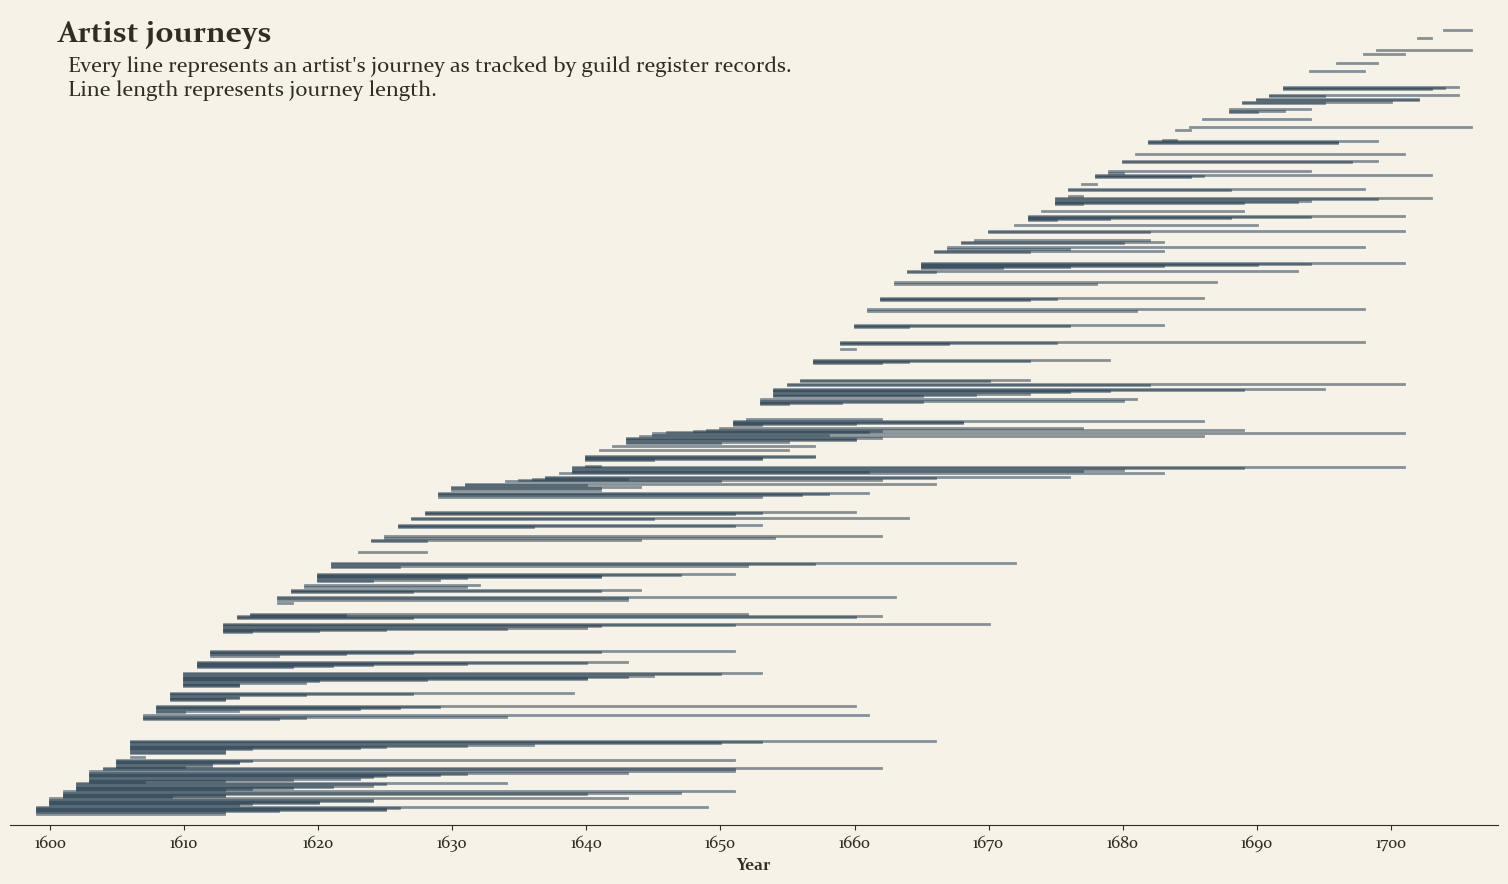

In [372]:
# --- data prep ---
# sort journeys by journey start date
journeys = sorted(journeys, key=lambda journey: journey["x"][0])

# --- fig setup ---
fig = plt.figure(figsize = (19.20, 10.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1)

# --- plot ---
i = 0
for journey in journeys:
    ax.plot(journey["x"],
            [i for x in range(0, len(journey["x"]))],
            c="#223B4E88",
            lw=2)
    i += 1

# --- config ---
# spines, axes and axis ticks
for spine in ["left", "right", "top"]:
    ax.spines[spine].set_visible(False)

# axes
ax.set_ylim(-10, len(journeys) + 10)
ax.set_xlim(1599 - 2, 1706 + 2)

# axis ticks
ax.set_yticks([])
xticks = ax.set_xticks([i for i in range(1600, 1701, 10)])

# title, subtitles, axis labels, axis tick labels and annotations
# fig title
plt.figtext(s="Artist journeys",
          x=0.15,
          y=0.85,
          va="baseline",
          ha="left",
          fontsize=22,
          fontweight="bold")

# # fig subtitle
plt.figtext(s=("Every line represents an artist's journey as tracked by guild register records."
               "\nLine length represents journey length."),
          x=0.155,
          y=0.80,
          va="baseline",
          ha="left",
          fontsize=16,
          fontweight="normal")

# axis annotation
ax.set_xlabel("Year",
              fontsize=12,
              fontweight="bold")


This visualization clearly shows us that the length of the artist's journey in Brussels as recorded by the guild register varies greatly in length. Some artists seem to appear in the records for a long time (the lines representing them are very long) whereas some artists vanish from the records as fast as they appear (their lines are extremely short.)



Another point of interest is the fact that journey lengths seem to be getting shorter as journey start year increases. To see whether this is a real occurence, we can plot journey length and journey start year together and calculate some measures of correlation.

Text(1650, 66.5, "Pearson's r: -0.24")

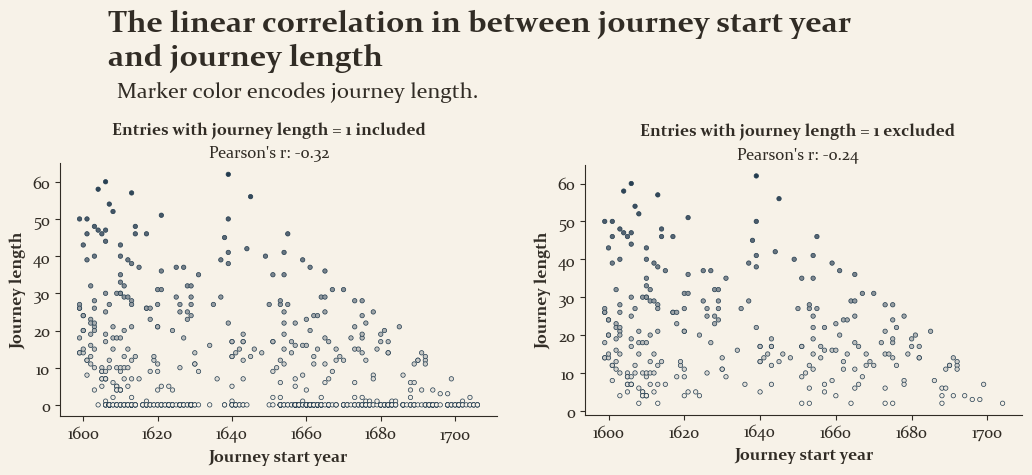

In [364]:
# --- data prep ---
x_1 = [journey["x"][0] for journey in journeys]
y_1 = [journey["journey_duration"] for journey in journeys]
corr_1 = np.corrcoef(x_1, y_1)

x_2 = [journey["x"][0] for journey in journeys if journey["journey_duration"] > 1]
y_2 = [journey["journey_duration"] for journey in journeys if journey["journey_duration"] > 1]
corr_2 = np.corrcoef(x_2, y_2)

xs = [x_1, x_2]
ys = [y_1, y_2]

# --- fig setup ---
fig = plt.figure(figsize = (19.20, 10.80),
                 dpi = 100)
sspec = fig.add_gridspec(ncols=2, nrows=1)
ax_1 = fig.add_subplot(spec[0, 0], aspect=1)
ax_2 = fig.add_subplot(spec[0, 1], aspect=1)

# --- plot ---
for ax, x, y in zip(fig.axes, xs, ys):
    ax.scatter(x=x, y=y,
               s=10, marker="o",
               linewidth=0.5,
               edgecolor="#223B4E",
               c=y,
               cmap=cmap)

# --- config ---
# spines, axes and axis ticks
    for spine in ["right", "top"]:
        ax.spines[spine].set_visible(False)

# axis annotation
    ax.set_xlabel("Journey start year",
                  fontsize=12,
                  fontweight="bold")
    ax.set_ylabel("Journey length",
                  fontsize=12,
                  fontweight="bold")

# fig title
plt.figtext(s=("The linear correlation in between journey start year\n"
               "and journey length"),
          x=0.15,
          y=0.92,
          va="baseline",
          ha="left",
          fontsize=22,
          fontweight="bold")

# # # fig subtitle
plt.figtext(s="Marker color encodes journey length.",
          x=0.155,
          y=0.89,
          va="baseline",
          ha="left",
          fontsize=16,
          fontweight="normal")

fig.axes[0].text(s="Entries with journey length = 1 included",
    x=1650,
    y=72.5,
    va="baseline",
    ha="center",
    fontsize=12,
    fontweight="bold")

fig.axes[0].text(s="Pearson's r: {:.2f}".format(corr_1[0][1]),
    x=1650,
    y=66.5,
    va="baseline",
    ha="center",
    fontsize=12,
    fontweight="normal")

fig.axes[1].text(s="Entries with journey length = 1 excluded",
    x=1650,
    y=72.5,
    va="baseline",
    ha="center",
    fontsize=12,
    fontweight="bold")

fig.axes[1].text(s="Pearson's r: {:.2f}".format(corr_2[0][1]),
    x=1650,
    y=66.5,
    va="baseline",
    ha="center",
    fontsize=12,
    fontweight="normal")

This perceived relation does not seem to hold true when we calculate the Pearson's correlation co-efficient in between journey start year and journey length. The negative correlation in between the two variables is very mild (-0.32) and it gets even milder (-0.24) once we discount the artist journeys that last only a year.

#### Journey through the ranks

Perhaps the most important feature in the dataset that is closely tied to an artist's journey as recorded by the Brussels guild register is actor status. We mentioned before that the feature "actor status" could be thought of in a hierarchical way. Apprentices rank lower than masters, masters rank lower than tutors (masters with one or more students), and tutors rank lower than deans. With this in mind, we can also track an artist's journey over time in relation to that artist's status (rank) within the guild. This way, we can see how each individual artist's career progression.

Below is a data visualization that visualizes each artist's journey through the ranks. Once again, non-sworn in master's and master's sons are excluded from the data visualization because there isn't much information about the location of these status within the status hierarchy.

[Text(0, 1, 'Apprentice'),
 Text(0, 2, 'Master'),
 Text(0, 3, 'Tutor'),
 Text(0, 4, 'Dean')]

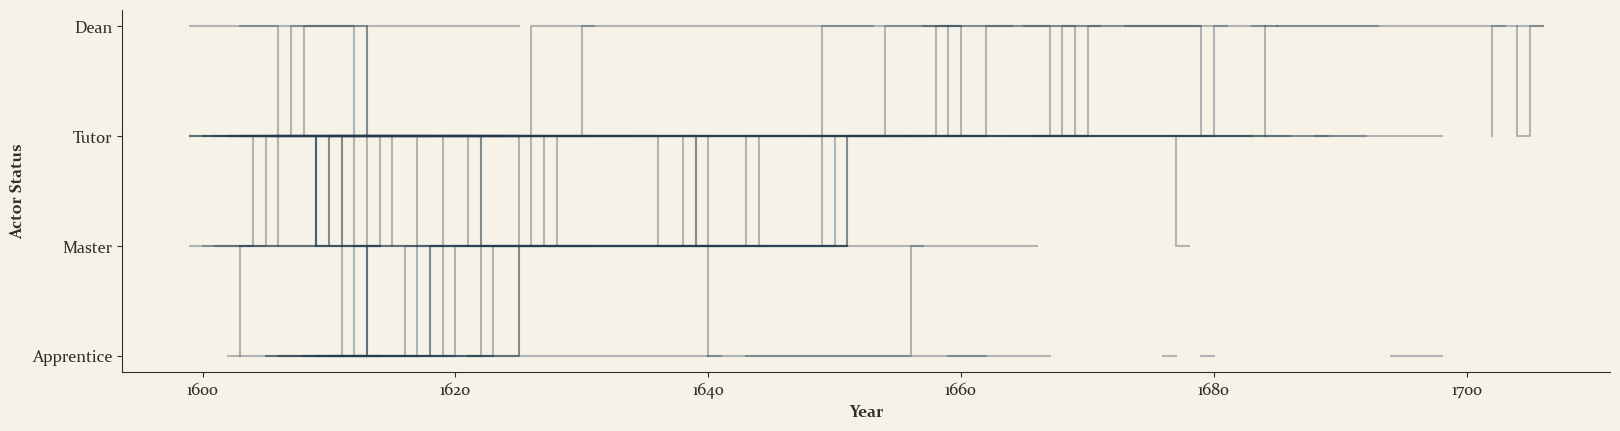

In [374]:
# --- fig setup ---
fig = plt.figure(figsize = (19.20, 4.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1)

# --- plot ---
for journey in journeys:
    if max(journey["y"]) <=4:
        ax.step(journey["x"],
                journey["y"],
                c="#223B4E55")

# spines, axes and axis ticks
for spine in ["right", "top"]:
    ax.spines[spine].set_visible(False)

# axis ticks
ax.set_yticks([1, 2, 3, 4])
# ax.set_xticks()

# title, subtitles, axis labels, axis tick labels and annotations
# fig title
# plt.figtext(s="The distribution of entry years",
#           x=0.15,
#           y=0.97,
#           va="baseline",
#           ha="left",
#           fontsize=22,
#           fontweight="bold")

# # fig subtitle
# plt.figtext(s="Not all years between the minimum and the maximum have an entry.",
#           x=0.155,
#           y=0.945,
#           va="baseline",
#           ha="left",
#           fontsize=16,
#           fontweight="normal")

# # axis annotation
ax.set_ylabel("Actor Status",
              fontsize=12,
              fontweight="bold")

ax.set_xlabel("Year",
              fontsize=12,
              fontweight="bold")

# axis tick labels
ax.set_yticklabels(["Apprentice", "Master", "Tutor", "Dean"])
